# 머신러닝 프로젝트 처음부터 끝까지

![머신러닝프로젝트처음부터끝까지3](머신러닝프로젝트처음부터끝까지3.png)

환경설정

In [1]:
import sys
import sklearn
import numpy as np
import os

# 그래프
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 2.1 1990 캘리포니아 인구조사 데이터

## 2.2 캘리포니아 인구조사 데이터를 활용해 주택 가격 모델을 만들기
### 2.2.1 문제 정의
#### 목적이 무엇인지 / 어떻게 사용할지 / 구성 / 알고리즘 등등 여러 구성 요소 결정
* 다중회귀 : 설명변수(독립변수, 입력변수)가 여러 개인 회귀 분석
* 단변량회귀 : 반응변수(종속변수, 출력변수)가 한 개인 회귀 분석
* 다변량회귀 : 반응변수(종속변수, 출력변수)가 여러 개인 회귀 분석

### 2.2.2 성능 측정 지표
* 평균 제곱근 오차(RMSE, Root Mean Square Error)   
* 평균 절대 오차(MAE, Mean Absolute Error)

## 2.3 데이터 가져오기
### 2.3.2 데이터 다운로드

In [2]:
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### 2.3.3 데이터 구조 훑어보기

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### 데이터 변수 설명
longitude : 경도  
latitude : 위도  
housing_median_age : 집 연식 중간값  
total_rooms : 총 방 수  
total_bedrooms : 총 침실 수  
population : 인구  
housholds : 세대  
median_income : 소득 중앙값  
median_house_value : 주택 가치 중앙값  
ocean_proximity : 바다 근접도  

#### 데이터 설명 : 행 수, 데이터 타입, Null 값 여부

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- total_bedrooms 167개의 null 값
- ocean_proximity는 범주형, 나머지는 연속형 숫자

In [7]:
# ocean_proxivity 범주 확인
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# 숫자형 특성 요약 정보
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- null 값을 제외한 정보들

#### 숫자형 변수 히스토그램 확인

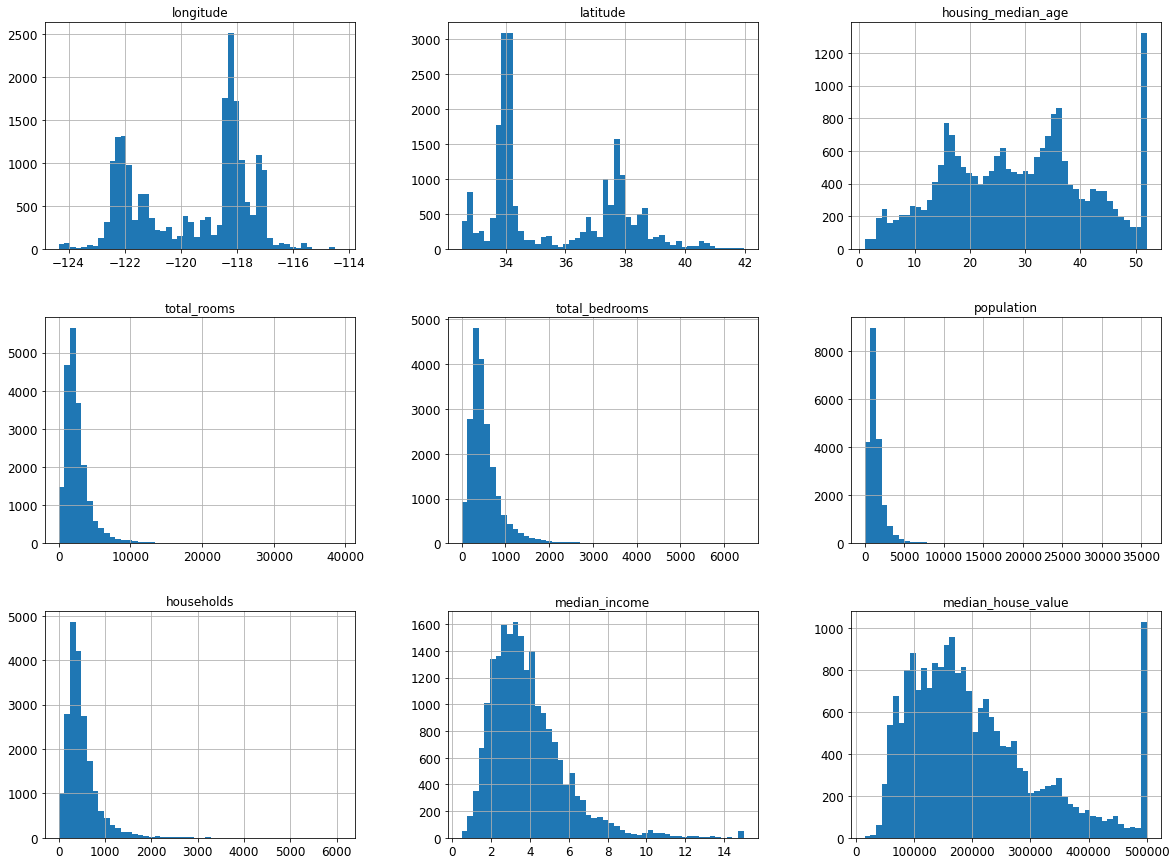

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))

plt.show()

- 중간소득(median income)이 US 달러로 표현 되어 있지 않음
- 중간주택연도(housing median age)와 중간주택가격(housing median value) 마지막 부분에 히스토그램이 높아지는 것을 보아 마지막 값으로 한정되었음을 짐작할 수 있음

### 2.3.4 테스트 세트 만들기

In [11]:
# 테스트 데이터 분리
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
# 20% 테스트 데이터 생성
train_set, test_set = split_train_test(housing, 0.2)

In [13]:
print(len(train_set))
print(len(test_set))

16512
4128


#### 업데이트 된 데이터셋을 사용하기 위한 설정

In [14]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
# 인덱스 컬럼 생성
housing_with_id = housing.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
# 값이 변하지 않는 위도, 경도를 합해 "id" 컬럼 생성
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [18]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [19]:
# id 추가 후 생성된 test set 확인
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


##### sklearn을 사용한 train, test split

In [20]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


#### 계층적 샘플링 구성

<AxesSubplot:>

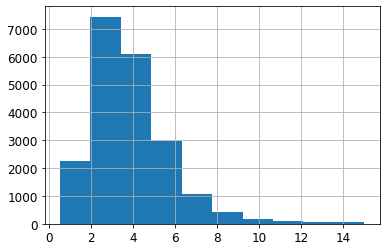

In [21]:
housing["median_income"].hist()

- 중간소득에서 적당한 계층 5개를 분류

In [22]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [23]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

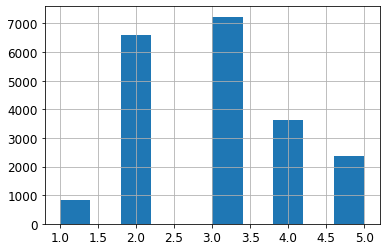

In [24]:
housing["income_cat"].hist()

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
# 만들어진 계층 비율 확인
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [27]:
# 실제 전체 비율 확인
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

#### 계층 샘플링과 순수한 무작위 샘플링의 샘플링 편향 비교

In [28]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [29]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


- 무작위 샘플링 오류율은 0에 가까운 것을 볼 수 있음

In [30]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 2.4 데이터 이해를 위한 탐색과 시각화
#### 훈련 세트 복사본 생성

In [31]:
housing = strat_train_set.copy()

### 2.4.1 지리적 데이터 시각화

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

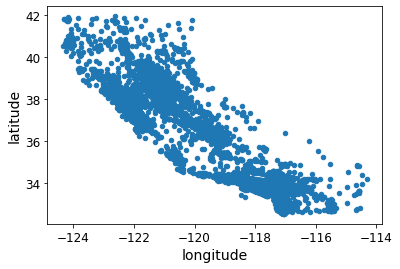

In [32]:
# 지리정보(위도, 경도)를 산점도로 시각화
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

- 캘리포니아 지역을 잘 보여주지만 특별한 패턴은 찾기 힘듦

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

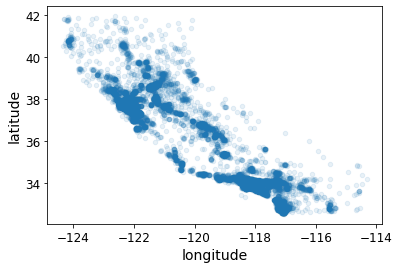

In [33]:
# alpha 옵션을 0.1로 설정해 데이터 포인트가 밀집된 영역을 보여줌
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

- 베이 에어리어와 로스앤젤레스 근처, 샌디에고는 밀집되어 있음
- 센트럴 벨리 특히 새크라멘토, 프레즈노 근처를 따라 밀집된 지역이 긴 띠를 이루고 있음

#### 주택 가격 나타내기
- 원의 반지름은 인구, 색상은 가격을 나타냄

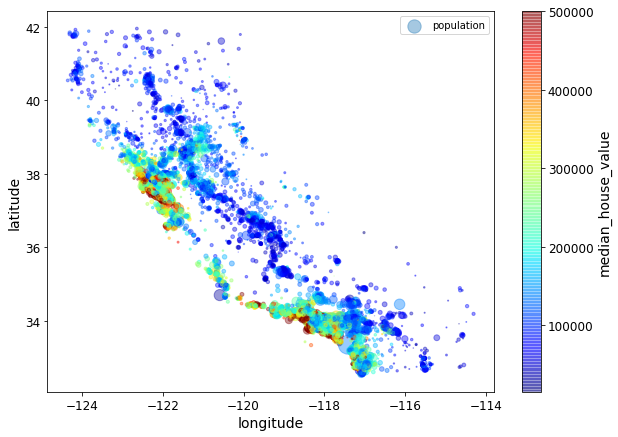

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

- 주택 가격은 지역 특성과 인구 밀도에 관련성이 매우 큼

### 2.4.2 상관관계 조사
#### 데이터 셋이 너무 크지 않아 모든 특성 간 표준 상관계수(피어슨 상관계수) 계산

In [35]:
corr_matrix = housing.corr()

In [36]:
# 중간주택가격과 다른 특성 사이의 상관관계 크기
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

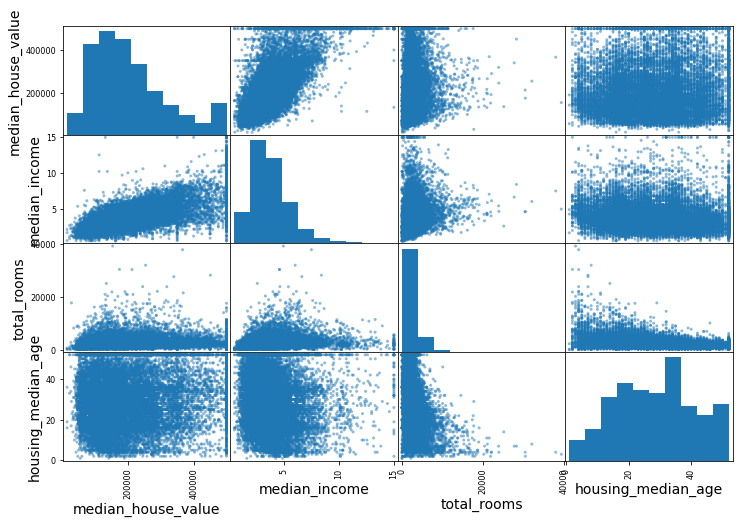

In [37]:
'''중간주택가격과 상관관계가 높아보이는 몇 개의 특성들
(중간소득, 총방의수, 중간주택연식)의 상관관계 산점도'''

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

- 중간주택 가격과 중간소득이 상관관계가 있어보여 산점도 확대

(0.0, 16.0, 0.0, 550000.0)

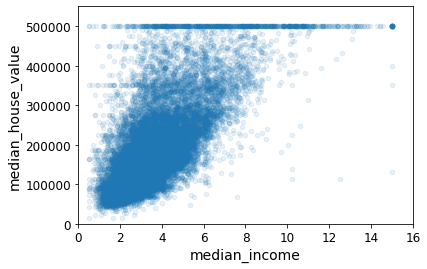

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

#### 알 수 있는 것들
- 상관관계가 매우 강함
- 앞에서 봤던 가격 제한값이 수평선으로 잘 보임
- 이러한 이상한 형태를 학습하지 않도록 해당 구역 제거 필요

### 2.4.3 특성 조합으로 실험
#### 특정 구역의 가구 당 방 개수와 가구 당 인원 수를 알기 위해 특성을 만들어봄

In [39]:
# 가구 당 방 개수
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

# 방 당 총 침실 수
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

# 가구 당 인원
housing["population_per_household"]=housing["population"]/housing["households"]

In [40]:
# 새로운 상관관계 확인
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

- 방 당 침실 수는 전체 방 개수나 전체 침실 개수보다 중간주택가격과의 상관관계가 높음
- 침대/방의 비율이 낮은 집은 더 비싼 경향이 있음

## 2.5 머신러닝 알고리즘을 위한 데이터 준비
- 원래 훈련 세트 복원(strat_train_set 다시 복사)
- 예측 변수와 타깃값에 같은 변형을 적용하지 않기 위해 예측 변수와 레이블을 분리

In [41]:
housing = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1 데이터 정제
#### total_bedrooms에 대한 값 처리 방법
- 해당 구역 제거 / 전체 특성 삭제 / 다른 값으로 대체

In [42]:
# total_bedrooms 결측 부분 확인
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [43]:
# 해당 구역 제거
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [44]:
# 전체 특성 제거
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [45]:
# 다른 값으로 대체(중앙값)
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


#### 중간값으로 대체하는 다른 방법

In [46]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [47]:
# 중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성 ocean_proximity 제외한 복사본 생성
housing_num = housing.drop("ocean_proximity", axis=1)

In [48]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [49]:
# imputer를 사용해 훈련 세트에서 누락된 값을 학습한 중간값으로 변경
X = imputer.transform(housing_num)

In [50]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [51]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [52]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.6 MB


### 2.5.2 텍스트와 범주형 특성 다루기

In [53]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


- 범주형 특성들을 숫자로 변환

In [54]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

- 이해가 가지 않음

In [55]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- 이 방법은 가까이 있는 값을 비슷하다고 생각하는 경향이 있음
- 이를 방지하기 위해 카테고리별 이진 특성으로 분류하는 원-핫 인코딩이 필요함

In [56]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

- 1을 제외한 0을 모두 메모리에 저장하는 것은 낭비이므로 사이파이희소행렬은 0의 위치만 저장

In [57]:
# toarray()를 사용해 넘파이 배열로 변경
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [58]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 2.5.3 나만의 변환기

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [60]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

In [61]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


- 잘 모르겠음

### 2.5.4 특성 스케일링
#### 모든 특성의 범위를 같게 해줘야 함
- min-max 스케일링(정규화)과 표준화가 널리 사용됨

### 2.5.5 변환 파이프라인
#### 연속된 변환을 순서대로 처리할 수 있도록 도와주는 Pipeline 클래스

#### 파이프라인 전반적으로 이해가 가지 않음

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [63]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [64]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [65]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [66]:
housing_prepared.shape

(16512, 16)

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [68]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [69]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [70]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [71]:
np.allclose(housing_prepared, old_housing_prepared)

True

## 2.6 모델 선택과 훈련
### 2.6.1 훈련 세트에서 훈련하고 평가하기
- 선형 회귀 모델 훈련

In [72]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [73]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


- 실제값과 비교

In [74]:
print("레이블:", list(some_labels))

레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


- 사이킷런의 mean_square를 사용해 전체 훈련 세트에 대한 회귀모델의 RMSE 측정

In [75]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

- 대부분 구역의 중간주택가격은 120,000달러에서 265,000달러 사이인데, 예측오차가 68,628인 것은 만족스럽지 못함
- 이는 모델이 훈련데이터에 과소적합된 사례

In [76]:
# 결정트리회귀 훈련
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [77]:
# 훈련세트로 평가
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

- 오차가 0.0이므로 모델이 과대적합 되었음을 알 수 있음
- 훈련세트 일부로 검증이 필요

### 2.6.2 교차 검증을 사용한 평가
- 훈련세트를 폴드(fold)라 불리는 10개의 서브셋으로 무작위 분할
- 결정트리 모델을 10번 훈련하고 평가하는데, 매번 다른 폴드를 선택해 평가에 사용하고, 나머지는 훈련에 사용
- 10개의 평가 점수가 담긴 배열이 결과가 됨

In [78]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [79]:
def display_scores(scores):
    print("교차검증점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

print("결정트리모델")
display_scores(tree_rmse_scores)

결정트리모델
교차검증점수: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
평균: 71407.68766037929
표준 편차: 2439.4345041191004


- 표준편차로는 이 추정이 얼마나 정확한지 측정할 수 있음
- 비교를 위해 선형회귀모델 점수 계산

In [80]:
print("선형회귀모델")
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

선형회귀모델
교차검증점수: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균: 69052.46136345083
표준 편차: 2731.6740017983493


- 결정트리모델이 과대적합되어 선형회귀모델보다 성능이 나쁨
- 랜덤포레스트 계산

In [81]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [82]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [83]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("랜덤포레스트")
display_scores(forest_rmse_scores)

랜덤포레스트
교차검증점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준 편차: 2097.0810550985693


- 훈련세트에 대한 점수가 검증세트에 대한 점수보다 훨씬 낮아 훈련세트에 과적합 되어있음

## 2.7 모델 세부 튜닝
### 2.7.1 그리드 탐색
- 가능성 있는 모델을 추린 후, 이를 세부 튜닝
- RandomForestRegressor에 대한 최적 하이퍼파라미터 조합 탐색

In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어남
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

- 최적의 파라미터 조합

In [85]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

- 최적의 추정기에 직접 접근

In [86]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

- 평가 점수 확인

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [88]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.086354,0.036585,0.005512,0.004010,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.430627,0.095183,0.013769,0.001426,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,1.167244,0.157913,0.047624,0.025373,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.240436,0.087056,0.009545,0.002308,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.508682,0.141943,0.009314,0.001891,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.372843,0.119491,0.048154,0.025764,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.198884,0.065289,0.004775,0.001691,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.614036,0.165724,0.014933,0.007305,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.907454,0.182286,0.043148,0.030825,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.247480,0.099164,0.004623,0.002148,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


- 'max_features': 8, 'n_estimators': 30 일 때 RMSE 점수가 49,682로 앞서 기본 하이퍼파라미터 설정으로 얻은 50,182보다 조금 더 좋음

### 2.7.2 랜덤 탐색
#### 그리드 탐색 방법은 비교적 적은 수의 조합을 탐구할 때 적합
#### 탐색 공간이 커지면 RandomizedSearchCV 사용하는 것이 더 좋음
- 가능한 모든 것을 시도하는 대신 각 반복마다 하이퍼파라미터에 임의의 수를 대입해 지정한 횟수만큼 평가

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028E779AFB20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028E77946490>},
                   random_state=42, scoring='neg_mean_squared_error')

In [91]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


### 2.7.4 최상의 모델과 오차 분석
#### RandomForestRegressor은 정확한 예측을 만들기 위한 각 특성의 상대적인 중요도를 알려줌

In [92]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [93]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

- 이 정보를 바탕으로 덜 중요한 특성을 제외할 수 있음
- 예를 들어 ocean_proxivity 중 하나(ISLAND)만 유용하므로 다른 카테고리 제외할 수 있음

### 2.7.5 테스트 세트로 시스템 평가하기
#### 모델을 얻게 되면 테스트 세트에서 최종 모델을 평가
- 테스트 세트에서 예측변수와 레이블을 얻은 후 full_pipeline을 사용해 데이터를 변환
- 테스트 세트에서 훈련하면 안되므로 fit_transform()이 아니라 transform()을 호출

In [94]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [95]:
final_rmse

47730.22690385927

- 이 추정값이 얼마나 정확한지 scipy.stats.t.interval()을 사용해 일반화 오차의 95% 신뢰구간을 계산

In [96]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])